# Solving combinatorial optimization problems using QAOA

In this tutorial, we introduce combinatorial optimization problems, explain approximate optimization algorithms, explain how the Quantum Approximate Optimization Algorithm (QAOA) works and present the implementation of an example that can be run on a simulator or on a 5 qubit quantum chip 

## Contents
1. [Introduction](#introduction)
2. [Examples](#examples)
3. [Approximate optimization algorithms](#approximateOPT)
4. [The QAOA algorithm](#QAOA)
5. [Qiskit Implementation](#implementation)    
    5.1 [Running QAOA on a simulator](#implementationsim)    
    5.2 [Running QAOA on a real quantum device](#implementationdev)
6. [Problems](#problems)
7. [References](#references)

## 1. Introduction <a id='introduction'></a>

Combinatorial optimization [1](#references) means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized, which is typically called the cost function. 

There are various types of optimization problems. These include Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects. Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects. Any maximization problem can be cast in terms of a minimization problem and vice versa. Hence the general form a combinatorial optimization problem is given by



$$ \text{maximize } \;\;      C(x)$$




$$ \text{subject to } \;\; x \in S $$



where $x \in S$, is a discrete variable and $C : D \rightarrow \mathbb{R}$ is the cost function, that maps from some domain $S$ in to the real numbers $\mathbb{R}$. The variable $x$ can be subject to a set of constraints and lies within the set $S \subset D$ of feasible points.

In binary combinatorial optimization problems, the cost function $C$ can typically be expressed as a sum of terms that only involve a subset $Q \subset[n]$ of the $n$ bits in the string $x \in \{0,1\}^n$ and is written in the canonical form



$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \prod_{i\in Q} x_i \; \prod_{j\in \overline{Q}} (1- x_j), $$



where $x_i \in \{0,1\}$ and $w_{(Q,\overline{Q})}\in \mathbb{R}$. We want to find the n-bit string $x$ for which $C(x)$ is the maximal.

### 1.1 Diagonal Hamiltonians

This cost function can be mapped to a Hamiltonian that is diagonal in the computational basis. Given the cost-function $C$ this Hamiltonian is then written as



$$ H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x| $$



where $x \in \{0,1\}^n$ labels the computational basis states $|x \rangle \in \mathbb{C}^{2^n}$. If the cost function only has at most weight $k$ terms, i.e. when only $Q$ contribute that involve at most $Q \leq k$ bits, then this diagonal Hamiltonian is also only a sum of weight $k$ Pauli $Z$ operators.

The expansion of $H$ in to Pauli $Z$ operators can be obtained from the canonical expansion of the cost-function $C$ by substituting for every binary variable $x_i \in \{0,1\}$ the matrix $x_i \rightarrow 2^{-1}(1 - Z_i)$. Here $Z_i$ is read as the Pauli $Z$ operator that acts on qubit $i$ and trivial on all others, i.e.



$$ Z_i = \left(\begin{array}{cc} 1 & 0 \\ 0 & -1 \end{array}\right). $$



This means that the spin Hamiltonian encoding the classical cost function is written as a $|Q|$ - local quantum spin Hamiltonian only involving Pauli $Z$- operators. 



$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) \; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$



Now, we will assume that only a few (polynomially many in $n$) $w_{(Q,\overline{Q})}$ will be non-zero. Moreover we will assume that the set $|(Q,\overline{Q})|$ is bounded and not too large. This means we can write the cost function as well as the Hamiltonian $H$ as the sum of $m$ local terms $\hat{C}_k$, 



$$ H = \sum_{k = 1}^m \hat{C}_k, $$



where both $m$ and the support of $\hat{C}_k$ is reasonably bounded.

## 2 Examples: <a id='examples'></a>

We consider 2 examples to illustrate combinatorial optimization problems. We will only implement the first example as in Qiskit, but provide a sequence of exercises that give the instructions to implement the second example as well.  


### 2.1 (weighted) $MAXCUT$

Consider an $n$-node non-directed graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(j,k)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$



To simplify notation, we assume uniform weights $ w_{ij} = 1$ for $(i,j) \in E$. In order to find a solution to this problem on a quantum computer, one needs first to map it to a diagonal  Hamiltonian as discussed above. We write the sum as a sum over edges in the set $(i,j) = E$ 



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$



To map is to a spin Hamiltonian we make the assignment $x_i\rightarrow (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$ and obtain $X \rightarrow H$



$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$



This means that the Hamiltonian can be written as a sum of $m = |E|$ local terms $\hat{C}_e = \frac{1}{2}\left(1 - Z_{e1}Z_{e2}\right)$ with $e = (e1,e2) \in E$. 


### 2.2 Constraint satisfaction problems and $MAX \; 3-SAT$.

Another example of a combinatorial optimization problem is $3-SAT$. Here the cost function $C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})$ is a sum of clauses $c_k(\textbf{x})$ that constrain the values of $3$ bits of some $\textbf{x} \in \{0,1\}^n$ that participate in the clause. Consider for instance this example of a $3-SAT$ clause 



$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$



for a bit string $\textbf{x} \in \{0,1\}^{133}$. The clause can only be satisfied by setting the bits $x_1 = 0$,$x_3 = 0$ and $x_{132} = 1$. The $3-SAT$ problem now asks whether there is a bit string that satisfies all of the $m$ clauses or whether no such string exists. This decision problem is the prime example of a problem that is $NP$-complete.  

The closely related optimization problem $MAX \; 3-SAT$ asks to find the bit string $\textbf{x}$ that satisfies the maximal number of of clauses in $C(\textbf{x})$. This can of course be turned again in to a decision problem if we ask where there exists a bit string that satisfies more than $\tilde{m}$ of the $m$ clauses, which is again $NP$-complete.

## 3. Approximate optimization algorithms <a id='approximateOPT'></a>

Both the previously considered problems $MAXCUT$ and $MAX \; 3-SAT$ are actually known to be a NP-hard problems [1](#references). In fact it turns out that many combinatorial optimization problems are computationally hard to solve in general. In light of this fact, we can't expect to find a provably efficient algorithm, i.e. an algorithm with polynomial runtime in the problem size, that solves these problems. This also applies to quantum algorithms. There are two main approaches to dealing with such problems. First approach is approximation algorithms that are guaranteed to find solution of specified quality in polynomial time. The second approach are heuristic algorithms that don't have a polynomial runtime guarantee but appear to perform well on some instances of such problems. 

Approximate optimization algorithms are efficient and provide a provable guarantee on how close the approximate solution is to the actual optimum of the problem. The guarantee typically comes in the form of an approximation ratio, $\alpha \leq 1$. A probabilistic approximate optimization algorithm guarantees that it produces a bit-string $\textbf{x}^* \in \{0,1\}^n$ so that *with high probability* we have that with a positive $C_{max} = \max_{\textbf{x}}C(\textbf{x})$ 



$$ C_{max} \geq C(\textbf{x}^*) \geq \alpha C_{max}. $$



For the $MAXCUT$ problem there is a famous approximate algorithm due to Goemans and Williamson [2](#references) . This algorithm is based on an SDP relaxation of the original problem combined with a probabilistic rounding technique that yields an with high probability approximate solution $\textbf{x}^*$ that has an approximation ratio of $\alpha \approx 0.868$. This approximation ratio is actually believed to optimal so we do not expect to see an improvement by using a quantum algorithm.

## 4. The QAOA algorithm <a id="QAOA"></a>
The Quantum approximate optimization algorithm (QAOA) by Farhi, Goldstone and Gutmann [3](#references) is an example of a heuristic algorithm. Unlike Goemans-Williamson algorithm, QAOA does not come with performance guarantees.
QAOA takes the approach of classical approximate algorithms and looks for a quantum analogue that will likewise produce a classical bit string $x^*$ that with high probability is expected to have a good approximation ratio $\alpha$. Before discussing the details, let us first present the general idea of this approach. 

### 4.1 Overview:

We want to find a quantum state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$, that depends on some real parameters $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$, which has the property that it maximizes the expectation value with respect to the problem Hamiltonian $H$. Given this trial state we search for parameters $\vec{\gamma}^*,\vec{\beta}^*$ that maximize $F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$. 

Once we have such a state and the corresponding parameters we prepare the state $|\psi_p(\vec{\gamma}^*,\vec{\beta}^*)\rangle$ on a quantum computer and measure the state in the $Z$ basis $|x \rangle = |x_1,\ldots x_n \rangle$ to obtain a random outcome $x^*$. 

We will see that this random $x^*$ is going to be a bit string that is with high probability close to the expected value $M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$. Hence, if $M_p$ is close to $C_{max}$ so is $C(x^*)$.

### 4.2 The components of the QAOA algorithm.

### 4.2.1 The QAOA trial state <a id="section_421"></a>
Central to QAOA is the trial state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ that will be prepared on the quantum computer. Ideally we want this state to give rise to a large expectation value $F_p(\vec{\gamma},\vec{\beta}) = \langle \vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ with respect to the problem Hamiltonian $H$. In Farhi [3](#references), the trial states $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ are constructed from the problem Hamiltonian $H$ together with single qubit Pauli $X$ rotations. That means, given a problems Hamiltonian 


$$ H = \sum_{k = 1}^m \hat{C}_k $$

 
diagonal in the computational basis and a transverse field Hamiltonian


$$ B = \sum_{i = 1}^n X_i $$


the trial state is prepared by applying $p$ alternating unitaries 



$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$



to the product state $|+\rangle^n$ with $ X |+\rangle = |+\rangle$. 

This particular ansatz has the advantage that there exists an explicit choice for the vectors $\vec{\gamma}^*,\vec{\beta}^*$ such that for $M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$ when we take the limit $\lim_{p \rightarrow \infty} M_p = C_{max}$. This follows by viewing the trial state $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ as the state that follows from troterizing the adiabatic evolution with respect to $H$ and the transverse field Hamiltonian $B$, c.f. Ref [3](#references).

Conversely the disadvantage of this trial state is one would typically want a state that has been generated from a quantum circuit that is not too deep. Here depth is measured with respect to the gates that can be applied directly on the quantum chip. Hence there are other proposals that suggest using Ansatz trial state that are more tailored to the Hardware of the quantum chip Ref. [4](#references), Ref. [5](#references).


### 4.2.2 Computing the expectation value <a id="section_422"></a>
An important component of this approach is that we will have to compute or estimate the expectation value 

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle 
$$

so we can optimize the parameters $\vec{\gamma},\vec{\beta}$. We will be considering two scenarios here. 

#### Classical evaluation
Note that when the circuit to prepare $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ is not too deep it may be possible to evaluate the expectation value $F_p$ classically.  

This happens for instance when one considers $MAXCUT$ for graphs with bounded degree and one considers a circuit with $p=1$. We will see an example of this in the Qiskit implementation below (section 5.2) and  provide an exercise to compute the expectation value.

To illustrate the idea, recall that the Hamiltonian can be written as a sum of individual terms $H = \sum_{k = 1}^m \hat{C}_k$. Due to the linearity of the expectation value, it is sufficient to consider the expectation values of the individual summands. For $p = 1$ one has that 



$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle.$$



Observe that with $B = \sum_{i = 1}^n X_i$ the unitary $e^{ -i\beta_1 B }$ is actually a product of single qubit rotations about $X$ with an angle $\beta$ for which we will write $X(\beta)_k = \exp(i\beta X_k)$. 

All the individual rotations that don't act on the qubits where $\hat{C}_k$ is supported commute with $\hat{C}_k$ and therefore cancel. This does not increase the support of the operator $\hat{C}_k$. This means that the second set of unitary gates $e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)$ have a large set of gates $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ that commute with the operator $e^{ i\beta_1 B } \hat{C}_k  e^{ -i\beta_1 B }$. The only gates $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ that contribute to the expectation value are those which involve qubits in the support of the original $\hat{C}_k$. 

Hence, for bounded degree interaction the support of $e^{ i\gamma_1 H } e^{   i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }$ only expands by an amount given by the degree of the interaction in $H$ and is therefore independent of the system size. This means that for these smaller sub problems the expectation values are independent of $n$ and can be evaluated classically. The case of a general degree $3$ is considered in [3](#references).

This is a general observation,  which means that if we have a problem where the circuit used for the trial state preparation only increases the support of each term in the Hamiltonian by a constant amount the cost function can be directly evaluated. 

When this is the case, and only a few parameters $\beta, \gamma$ are needed in the preparation of the trial state,
these can be found easily by a simple grid search. Furthermore, an exact optimal value of $M_p$ can be used to bound the approximation ratio



$$ \frac{M_p}{C_{max}} \geq \alpha $$



to obtain an estimate of $\alpha$. For this case the QAOA algorithm has the same characteristics as a conventional approximate optimization algorithm that comes with a guaranteed approximation ratio that can be obtained with polynomial efficiency in the problem size.


#### Evaluation on a quantum computer

When the quantum circuit becomes too deep to be evaluated classically, or when the connectivity of the Problem Hamiltonian is too high we can resort to other means of estimating the expectation value. This involves directly estimating $F_p(\vec{\gamma},\vec{\beta})$ on the quantum computer. The approach here follows the path of the conventional expectation value estimation as used in VQE [4](#references), where a trial state $| \psi(\vec{\gamma},\vec{\beta})$ is prepared directly on the quantum computer and the expectation value is obtained from sampling.

Since QAOA  has a diagonal Hamiltonian $H$ it is actually straight forward to estimate the expectation value. We only need to obtain samples from the trial state in the computational basis. Recall that $H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|$ so that we can obtain the sampling estimate of 



$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$



by repeated single qubit measurements of the state $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle $ in the $Z$ basis. For every bit string $x$ obtained from the distribution $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ we evaluate the cost function $C(x)$ and average it over the total number of samples. The resulting empirical average approximates the expectation value up to an additive sampling error that lies within the variance of the state. The variance will be discussed below.

With access to the expectation value, we can now run a classical optimization algorithm, such as [6](#references),
to optimize the $F_p$.

While this approach does not lead to an a-priori approximation guarantee for $x^*$, the optimized function value 
can be used later to provide an estimate for the approximation ratio $\alpha$.


### 4.3.3 Obtaining a solution with a given approximation ratio with high probability
The algorithm is probabilistic in nature and produces random bit strings from the distribution $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$. So how can we be sure that we will sample an approximation $x^*$ that is close to the value of the optimized expectation value $M_p$? Note that this question is also relevant to the estimation of $M_p$ on a quantum computer in the first place. If the samples drawn from $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ have too much variance, many samples are necessary to determine the mean. 

We will draw a bit string $x^*$ that is close to the mean $M_p$ with high probability when the energy as variable has little variance.

Note that the number of terms in the Hamiltonian $H = \sum_{k=1}^m \hat{C}_k$ are bounded by $m$. Say each individual 
summand $\hat{C}_k$ has an operator norm that can be bounded by a universal constant $\|\hat{C}_k\| \leq \tilde{C}$ for all $k = 1\ldots m$. Then consider 

$$
\begin{eqnarray}
\langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &\leq & \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \\\nonumber
&=& \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \\\nonumber 
&\leq& m^2 \tilde{C}^2 \\\nonumber
\end{eqnarray}
$$


where we have used that 
$\langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2$. 


This means that the variance of any expectation $F_p(\vec{\gamma},\vec{\beta})$ is bounded by $m^2 \tilde{C}^2$. Hence this in particular applies for $M_p$. Furthermore if $m$ only grows polynomially in the number of qubits $n$, we know that taking polynomially growing number of samples $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon^2}\right)$ from $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ will be sufficient to obtain a $x^*$ that leads to an $C(x^*)$ that will be close to $M_p$.

## 5. Qiskit Implementation<a id='implementation'></a>

As the example implementation we consider the $MAXCUT$ problem on the butterfly graph of the openly available IBMQ 5-qubit chip. The graph will be defined below and corresponds to the native connectivity of the device. This allows us to implement the original version of the $QAOA$ algorithm, where the cost function $C$ and the Hamiltonian $H$ that is used to generate the state coincide. Moreover, for such a simple graph the exact cost function can be calculated analytically, avoiding the need to find optimal parameters variationally [7](#references). To implement the circuit, we follow the notation and gate definitions from the [Qiskit Documentation](https://qiskit.org/documentation/).

As the first step will will load Qiskit and additional python packages.

In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

### 5.1 Problem definition 

We define the cost function in terms of the butterfly graph of the superconducting chip. The graph has $n = 5$ vertices $ V = \{0,1,2,3,4,5\}$ and six edges $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$, which will all carry the same unit weight $w_{ij} = 1$. We load an additional network package to encode the graph and plot connectivity below.

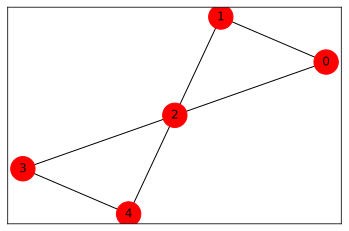

In [2]:
# Generating the butterfly graph with 5 nodes 
n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

### 5.2 Optimal trial state parameters<a id="implementation_sec52"></a>

In this example we consider the case for $p = 1$, i.e. only layer of gates. The expectation value $F_1(\gamma,\beta) = \langle \psi_1(\gamma,\beta))|H|\psi_1(\gamma,\beta) \rangle$ can be calculated analytically for this simple setting. Let us discuss the steps explicitly for the Hamiltonian $H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_i Z_k\right)$. Due to the linearity of the expectation value we can compute the expectation value for the edges individually



$$f_{(i,k)}(\gamma,\beta) =  \langle \psi_1(\gamma,\beta)|\;\frac{1}{2}\left(1 - Z_i Z_k\right)\;|\psi_1(\gamma,\beta)\rangle. $$



For the butterfly graph as plotted above, we observe that there are only two kinds of edges $A = \{(0,1),(3,4)\}$ and 
$B = \{(0,2),(1,2),(2,3),(2,4)\}$. The edges in $A$ only have two neighboring edges, while the edges in $B$ have four. You can convince yourself that we only need to compute the expectation of a single edge in each set since the other expectation values will be the same. This means that we can compute $F_1(\gamma,\beta) = 2 f_A(\gamma,\beta) + 4f_B(\gamma,\beta)$ by evaluating only computing two expectation values. Note, that following the argument as outlined in [section 4.2.2](#section_422), all the gates that do not intersect with the Pauli operator $Z_0Z_1$ or $Z_0Z_2$ commute and cancel out so that we only need to compute



$$f_A(\gamma,\beta) = \frac{1}{2}\left(1 - \langle +^3|U_{21}(\gamma)U_{02}(\gamma)U_{01}(\gamma)X_{0}(\beta)X_{1}(\beta)\;Z_0Z_1\; X^\dagger_{1}(\beta)X^\dagger_{0}(\beta)U^\dagger_{01}(\gamma)U^\dagger_{02}(\gamma)U^\dagger_{12}(\gamma)  | +^3 \rangle \right)$$



and



$$f_B(\gamma,\beta) = \frac{1}{2}\left(1 - \langle +^5|U_{21}(\gamma)U_{24}(\gamma)U_{23}(\gamma)U_{01}(\gamma)U_{02}(\gamma)X_{0}(\beta)X_{2}(\beta)\;Z_0Z_2\; X^\dagger_{0}(\beta)X^\dagger_{2}(\beta)U^\dagger_{02}(\gamma)U^\dagger_{01}(\gamma)U^\dagger_{12}(\gamma)U^\dagger_{23}(\gamma)U^\dagger_{24}(\gamma)  | +^5 \rangle \right)$$



How complex these expectation values become in general depend only on the degree of the graph we are considering and is independent of the size of the full graph if the degree is bounded. A direct evaluation of this expression with $U_{k,l}(\gamma) = \exp\frac{i\gamma}{2}\left(1 - Z_kZ_l\right)$ and  
$X_k(\beta) = \exp(i\beta X_k)$ yields 



$$f_A(\gamma,\beta) = \frac{1}{2}\left(sin(4\gamma)sin(4\beta) + sin^2(2\beta)sin^2(2\gamma)\right)$$



and



$$f_B(\gamma,\beta) = \frac{1}{2}\left(1 - sin^2(2\beta)sin^2(2\gamma)cos^2(4\gamma) - \frac{1}{4}sin(4\beta)sin(4\gamma)(1+cos^2(4\gamma))\right) $$



These results can now be combined as described above, and the expectation value is therefore given by



$$ F_1(\gamma,\beta) = 3 - \left(sin^2(2\beta)sin^2(2\gamma)- \frac{1}{2}sin(4\beta)sin(4\gamma)\right)\left(1  + cos^2(4\gamma)\right),$$



We plot the function $F_1(\gamma,\beta)$ and use a simple grid search to find the parameters $(\gamma^*,\beta^*)$
that maximize the expectation value.

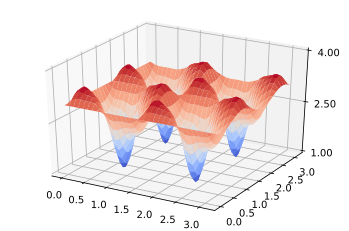


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [3]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

### 5.3 Quantum circuit<a id="implementation_sec53"></a>

With these parameters we can now construct the circuit that prepares the trial state for the Graph
or the Graph $G = (V,E)$ described above with vertex set $V = \{0,1,2,3,4\}$ and the edges are $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$. The circuit is going to require $n = 5$ qubits and we prepare the state 



$$ |\psi_1(\gamma ,\beta)\rangle = e^{ -i\beta B } e^{ -i\gamma H } |+\rangle^n.  $$



Recall that the terms are given by $B = \sum_{k \in V} X_k$ and $H = \sum_{(k,m) \in E} \frac{1}{2}\left(1 - Z_kZ_m\right)$. To generate the circuit we follow these steps:

 - We first implement 5 Hadamard $H$ gates to generate the uniform superposition.
 

 - This is follow by $6$ Ising type gates $U_{k,l}(\gamma)$ with angle $\gamma$ along the edges $(k,l) \in E$. This gate can be expressed in terms of the native Qiskit gates as

  

$$ U_{k,l}(\gamma) = C_{u1}(-2\gamma)_{k,l}u1(\gamma)_k u1(\gamma)_l$$


  
 
 - Lastly we apply single qubit $X$ rotations $X_k(\beta)$ for every vertex $k \in V$ with $\beta$ as angle. This gate directly parametrized as $X_k(\beta) = R_x(2\beta)_k$ in Qiskit.
 

 - In the last step we measure the qubits in the computational basis, i.e. we perform a $Z$ measurement and record the resulting bit-string $x \in \{0,1\}^5$.

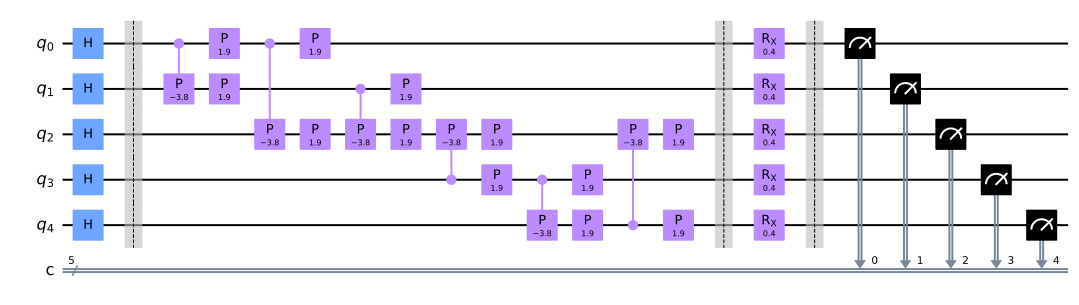

In [4]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    
# then apply the single qubit X rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw()

### 5.4  Cost function evaluation<a id="implementation_sec54"></a>

Finally, we need a routine to compute the cost function value from the bit string. 
This is necessary to decide whether we have found a "good candidate" bit string $x$ but could also 
be used to estimate the expectation value $F_1(\gamma,\beta)$ in settings where the expectation value can not be evaluated directly.

In [5]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

## 5a. Running QAOA on a simulator<a id="implementationsim"></a>

We first run the algorithm on a local QASM simulator.

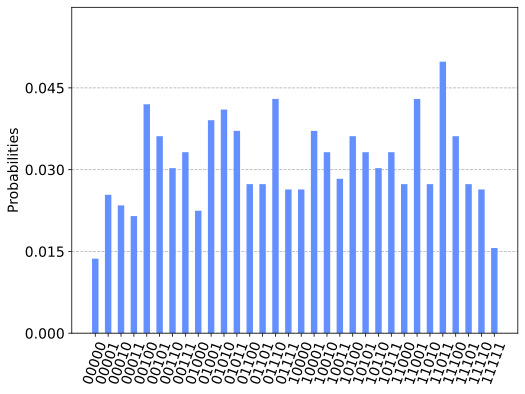

In [6]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

#### Evaluate the date from the simulation

Let us now proceed to calculate the relevant information from the simulated data. We will use the 
obtained results to 

- Compute the mean energy and check whether it agrees with the theoretical prediction
- Report the sampled bit string $x^*$ with the largest observed cost function $C(x^*)$ 
- Plot the Histogram of the energies to see whether it indeed concentrates around the predicted mean


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 0.33 while the true value is M1 = 3.43 

The approximate solution is x* = 10001 with C(x*) = 4 

The cost function is distributed as: 



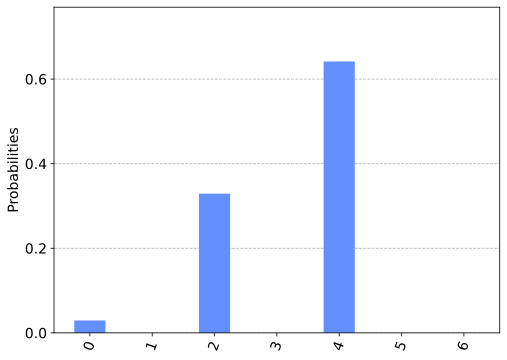

In [7]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

## 5b. Running QAOA on a real quantum device<a id="implementationdev"></a>

We then see how the same circuit can be executed on real-device backends.

In [8]:
# Use the IBMQ essex device
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
shots = 2048

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
job_exp = backend.run(qobj)
job_monitor(job_exp)

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Job Status: job has successfully run


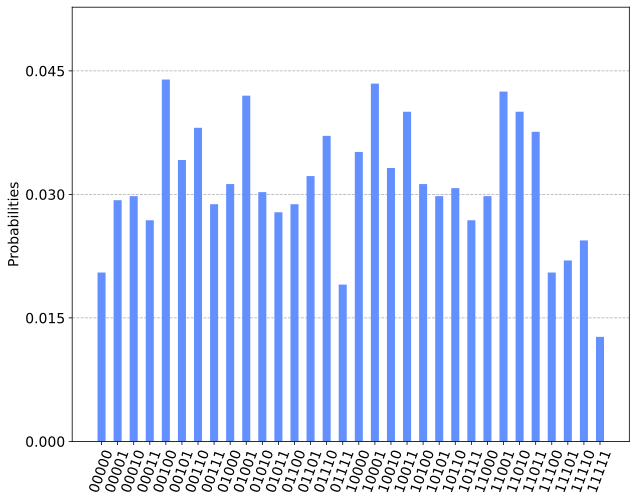

In [9]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)

#### Evaluate the data from the experiment

We can now repeat the same analysis as before and compare the experimental result.


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 3.22 while the true value is M1 = 3.43 

The approximate solution is x* = 10001 with C(x*) = 4 

The cost function is distributed as: 



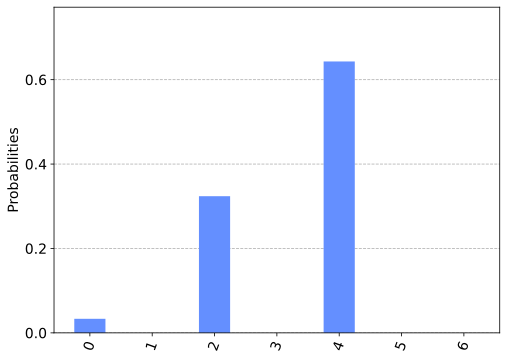

In [10]:
# Evaluate the data from the experiment
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

## 6. Problems<a id="problems"></a>

0. The QAOA algorithm produces a bit string, is this string the optimal solution for this graph? Compare the experimental results from the superconducting chip with the results from the local QASM simulation.


1. We have computed the cost function $F_1$  analytically in [section 5.2](#implementation_sec52). Verify the steps and compute $f_A(\gamma,\beta)$ as well $f_B(\gamma,\beta)$. 


2. We have given an exact expression for $F_1$ in the Qiskit implementation. 

      -Write a routine to estimate the expectation value $F_1(\gamma,\beta)$ from the samples obtained in the result (hint: use the function cost_function_C(x,G) from [section 5.4](#implementation_sec54) and the evaluation of the data in both section [5.a / 5.b](#implementationsim))
       
      -Use an optimization routine,e.g. SPSA from the VQE example in this tutorial, to optimize the parameters in the sampled $F_1(\gamma,\beta)$ numerically. Do you find the same values for $\gamma^*,\beta^*$ ?


3. The Trial circuit in [section 5.3](#implementation_sec53) corresponds to depth $p=1$ and was directly aimed at being compatible with the Hardware.

    -Use the routine from exercise 2 to evaluate the cost functions $F_p(\gamma,\beta)$ for $p=2,3$. What do you expect to see in the actual Hardware?
    
    -Generalize this class of trial state to other candidate wave functions, such as the Hardware efficient ansatz of Ref. [4](#references).
    

4. Consider an example of $MAX \;\; 3-SAT$ as discussed in the example section and modify the function cost_function_C(c,G) from [section 5.4](#implementation_sec54) you have used to compute $F_p$ accordingly. Run the QAOA algorithm for this instance of $MAX \; 3-SAT$ using the hardware efficient algorithm and analyze the results. 

## 7. References<a id="references"></a>

1. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [11]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}